# Develop weather-based model

The model uses weather observations from Central Park, as well as the ozone concentration at the current time, to predict future ozone concentrations at several locations in NYC. 

The model will eventually be deployed through a web application. When deployed, the model will probably use the current ozone concentration and weather forecasts over the following several days to predict ozone concentrations over those several days. 

In [1]:
import sqlite3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys

sys.path.append('../scripts')
from sql_functions import create_sql_connection, execute_sql_command
from global_vbls import data_path, db_file

from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

conn = create_sql_connection(db_file)

In [2]:
def check_o3_site_completeness(): 
    o3_df = pd.read_sql("SELECT * FROM o3_obs_nyc", conn, parse_dates='timestamp_local', 
                        index_col='timestamp_local')
    for id_n,df in o3_df.groupby('site_id'): 
        complete_ts = CompleteTimeSeries('20030101000000',pd.Timestamp.now(),frequency='H').fit_transform(df)
        pct_full = complete_ts['o3_ppm'].count()/len(complete_ts['o3_ppm'])*100
        print('site_id:',id_n,'... Pct complete:',pct_full)
    return None

def check_seasonal_features(time_vec):   
    seas_feats = seasonalFeatures(periods_days=[1,365]).fit_transform(time_vec)
    plt.figure(figsize=[13,4])
    for i in range(seas_feats.shape[1]): 
        plt.plot(time_vec,seas_feats[:,i])
    plt.show()
    return None

In [3]:
def cloud_class_from_code(cld_code):
    cloud_class_dict = {
        '0': 'missing',
        '1': 'clear',
        '2': 'scattered',
        '3': 'broken',
        '4': 'overcast',
        '5': 'obscured',
        '6': 'thin scattered',
        '7': 'thin broken',
        '8': 'thin overcast',
        '9': 'thin obscure'
    }
    if np.isnan(cld_code): 
        cld_class = 'missing'
    else: 
        cld_class = cloud_class_dict[str(int(cld_code))[-1]]
    return cld_class


def cloud_height_from_code(cld_code):
    if np.isnan(cld_code): 
        cld_hgt = np.nan
    elif str(int(cld_code))[-1]=='0' or len(str(int(cld_code)))==1: 
        cld_hgt = np.nan
    else: 
        cld_hgt = int(str(int(cld_code))[:-1])*100/3.281
    return cld_hgt


def decode_cloud_code(wx_df,layer=1): 
    wx_df['cld_class_'+str(layer)] = wx_df['cloud_layer_'+str(layer)+'_code']\
                                            .apply(cloud_class_from_code)
    wx_df['cld_hgt_'+str(layer)] = wx_df['cloud_layer_'+str(layer)+'_code']\
                                            .apply(cloud_height_from_code)
    wx_df = wx_df.drop('cloud_layer_'+str(layer)+'_code',axis=1)
    return wx_df

In [221]:
class CompleteTimeSeries(TransformerMixin, BaseEstimator): 
    
    def __init__(self,st_time, ed_time, frequency = 'H'): 
        self.st_time = st_time
        self.ed_time = ed_time
        self.frequency = frequency
    
    def fit(self, X, y=None): 
        
        if self.frequency == 'S': 
            periods = (pd.Timestamp(self.ed_time)-pd.Timestamp(self.st_time))//pd.Timedelta('1 seconds')
        elif self.frequency == 'M': 
            periods = (pd.Timestamp(self.ed_time)-pd.Timestamp(self.st_time))//pd.Timedelta('1 minutes')
        elif self.frequency == 'H': 
            periods = (pd.Timestamp(self.ed_time)-pd.Timestamp(self.st_time))//pd.Timedelta('1 hours')
        elif self.frequency == 'D': 
            periods = (pd.Timestamp(self.ed_time)-pd.Timestamp(self.st_time))//pd.Timedelta('1 days')
        else: 
            message = "Invalid input for frequency. Frequency must have values "+\
                      "in ['S', 'M', 'H', 'D']. You input: "+str(self.frequency)
            raise ValueError(message)
            
        self.all_times = pd.DataFrame({
            'timestamp_local': pd.date_range(self.st_time, periods=periods, freq=self.frequency),
        })
        
        return self
        
    def transform(self, X, y=None): 
        X = self.all_times.merge(X,how='left',
                                 left_on='timestamp_local',right_index=True)\
                                 .set_index('timestamp_local')
        return X
        
        
class SeasonalFeatures(TransformerMixin, BaseEstimator):
    """Analogous to sklearn.preprocessing.PolynomialFeatures, but creates sinusoidal 
    instead of polynomial features. 
    
    ATTRIBUTES: 
    ***********
    periods_days: list of the sinusoidal features' periods (in days). 
    A sine and cosine feature is created for each period in the list.  
    
    METHODS: 
    ********
    fit: returns self. 
    
    transform: Returns a numpy array of size (len(X), len(periods_days)*2). 
    This array contains both sine (even columns) and cosine features (odd columns)
    for each period. 
    """
    
    def __init__(self, periods_days=[1, 365]): 
        self.periods_days = periods_days
        self.ref_time = pd.Timestamp('20030101000000')
        
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None): 
        sorted_X = pd.Series(X).sort_values()
        days_since_start = np.array((sorted_X-self.ref_time)/pd.Timedelta('1 days'))
        final_array = np.zeros((len(sorted_X),2*len(self.periods_days)))
        for i,period in enumerate(self.periods_days): 
            final_array[:,2*(i-1)] = np.sin(2*np.pi*days_since_start/period)
            final_array[:,2*(i-1)+1] = np.cos(2*np.pi*days_since_start/period)
        return final_array
    

class SeasonalModel(RegressorMixin, BaseEstimator): 
    """Creates a seasonal model for a time series, given a datetime vector and 
    the time series values.
    
    ATTRIBUTES: 
    ***********
    periods_days: list of the periods over which seasonalities occur. For example, 
    a time series with daily and yearly seasonality will have periods of 1 day and 
    365 days. 
    
    METHODS: 
    ********
    fit: fits the model to the time series data. Inputs are X (a vector of time stamps),
    and y (a vector of time series values). 
    predict: uses the model to make predictions for new times. 
    """
    
    def __init__(self, periods_days=[1, 365]): 
        self.periods_days = periods_days
        self.seasonal_features = SeasonalFeatures(periods_days=self.periods_days)
        
    def fit(self, X, y): 
        seas_feats = self.seasonal_features.fit_transform(X)
        self.seas_reg = LinearRegression(fit_intercept=True).fit(seas_feats,y)
        return self
        
    def predict(self, X): 
        seas_feats = self.seasonal_features.transform(X)
        return self.seas_reg.predict(seas_feats)
        

class ConvertUTCToLocalTime(TransformerMixin, BaseEstimator):
    
    def __init__(self,tz='EST'): 
        self.tz = tz
        
    def check_initial_tz(self,X): 
        if str(wx_df.index[0].tzinfo) != 'UTC': 
            raise TypeError('Initial time zone is not UTC!')
        return None        
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None): 
        self.check_initial_tz(X)
        X = X.set_index(X.index.tz_convert(self.tz).tz_localize(tz=None))
        return X
    
    
class DecodeCloudCodes(TransformerMixin, BaseEstimator):
    
    def __init__(self,layers=[1,2,3]): 
        self.layers = layers
        self.cloud_class_dict = {
            '0': 'missing',
            '1': 'clear',
            '2': 'scattered',
            '3': 'broken',
            '4': 'overcast',
            '5': 'obscured',
            '6': 'thin scattered',
            '7': 'thin broken',
            '8': 'thin overcast',
            '9': 'thin obscure'
        }
        
    def cloud_class_from_code(self,cld_code):
        if np.isnan(cld_code): 
            cld_class = 'missing'
        else: 
            cld_class = self.cloud_class_dict[str(int(cld_code))[-1]]
        return cld_class  
    
    def cloud_height_from_code(cld_code):
        if np.isnan(cld_code): 
            cld_hgt = np.nan
        elif str(int(cld_code))[-1]=='0' or len(str(int(cld_code)))==1: 
            cld_hgt = np.nan
        else: 
            cld_hgt = int(str(int(cld_code))[:-1])*100/3.281
        return cld_hgt
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None): 
        for layer in self.layers: 
            X['cld_class_'+str(layer)] = X['cloud_layer_'+str(layer)+'_code']\
                                                    .apply(cloud_class_from_code)
            X['cld_hgt_'+str(layer)] = X['cloud_layer_'+str(layer)+'_code']\
                                                    .apply(cloud_height_from_code)
            #X = X.drop('cloud_layer_'+str(layer)+'_code',axis=1)
        return X
    

class FillnaSeasonal(TransformerMixin, BaseEstimator): 
    
    def __init__(self, cols = ['air_temp'], periods_days = [1,365]): 
        self.cols = cols
        self.periods_days = periods_days
        
    def fit(self, X, y=None): 
        self.seas_model_dict = dict()
        for col in self.cols: 
            dep_vbl = X[col].dropna()
            time_vec = dep_vbl.index.values
            seas_model = SeasonalModel(periods_days=self.periods_days).fit(time_vec,dep_vbl)
            self.seas_model_dict[col] = seas_model
        return self
    
    def transform(self, X, y=None): 
        
        def fillnas(row,col,seas_model): 
            if np.isnan(row[col]):
                return seas_model.predict(row.name)
            else: 
                return row[col]
        
        for col in self.cols: 
            X[col] = X.apply(fillnas,args=[col,self.seas_model_dict[col]],axis=1)
            
        return X
            

class CalculateWindUVComponents(TransformerMixin, BaseEstimator): 
    
    def __init__(self): 
        pass
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None): 
        X['u_wind'] = X['wind_speed']*np.cos(np.deg2rad(270-X['wind_direction']))
        X['v_wind'] = X['wind_speed']*np.sin(np.deg2rad(270-X['wind_direction']))
        return X

    
class FillnaInterpolation(TransformerMixin, BaseEstimator): 
    
    def __init__(self, cols=['wind_speed', 'wind_direction'], interp_limits=[12,12]): 
        self.cols = cols
        self.lims = interp_limits
        
    def fit(self, X, y=None): 
        return self
    
    def checkLengths(self): 
        if len(self.cols)!=len(self.lims): 
            raise(ValueError("Lengths of column name and interpolation limit lists are different."))
    
    def transform(self, X, y=None): 
        self.checkLengths()
        for col,lim in zip(self.cols, self.lims): 
            X[col] = X[col].interpolate(limit=12,limit_direction='forward',limit_area='inside')
        return X


class FillnaWindGust(TransformerMixin, BaseEstimator): 
    
    def __init__(self, wgust_col='wind_gust', wspd_col='wind_speed'):
        self.wgust_col = wgust_col
        self.wspd_col = wspd_col
        
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None): 
        def fill_gust(row, wgust_col, wspd_col): 
            return row[wspd_col] if np.isnan(row[wgust_col]) else row[wgust_col]        
        X[self.wgust_col] = X.apply(fill_gust, args=[self.wgust_col, self.wspd_col], axis=1)
        return X
    
    
class FillnaAccumPrecip(TransformerMixin, BaseEstimator): 
    
    def __init__(self, precip_col='precip_accum_one_hour'): 
        self.precip_col = precip_col
        
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None): 
        X[self.precip_col] = X[self.precip_col].fillna(value=0)
        return X
    

class CreateFinalCloudColumns1(TransformerMixin, BaseEstimator): 
    
    def __init__(self,layers=[1,2,3]): 
        self.layers = layers
        self.cld_class_to_frac = {
            'clear': 0.,
            'scattered': 1/3,
            'thin scattered': 1/3,
            'broken': 2/3,
            'thin broken': 2/3,
            'overcast': 1.,
            'thin overcast': 1.,
            'obscured': 1.,
            'missing': np.nan,
        }
        return None
    
    def update_total_frac(self,row,layer): 
        if layer == 1 or (layer > 1 and not np.isnan(row['cld_frac_'+str(layer)])): 
            new_total = row['cld_frac_total']+((1-row['cld_frac_total'])*row['cld_frac_'+str(layer)])
        elif layer > 1 and np.isnan(row['cld_frac_'+str(layer)]):
            new_total = row['cld_frac_total']
        return new_total
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None): 
        X['cld_frac_total'] = [0]*len(X.index.values)
        for layer in self.layers: 
            X['cld_frac_'+str(layer)] = X['cld_class_'+str(layer)]\
                                            .apply(lambda x: self.cld_class_to_frac[x])
            X['cld_frac_total'] = X.apply(self.update_total_frac, args=[layer], axis=1)   
        X['cld_hgt_total'] = X['cld_hgt_1'].copy()
        return X

    
class AddDatetimeFeatures(TransformerMixin, BaseEstimator): 
    
    def __init__(self,feats=['hourofday','dayofweek']):
        self.feats = feats
        self.acceptable_feats = ['hourofday','dayofweek','month']
        
    def test__feats(self): 
        bad_feats = [feat for feat in self.feats if feat not in self.acceptable_feats]
        try: 
            assert(not bad_feats)
        except AssertionError: 
            raise(ValueError('Datetime features '+str(bad_feats)+'are not acceptable. '+\
                             'Acceptable features include: '+str(self.acceptable_feats)+'.'))
    
    def test__datetime_index(self,X): 
        try: 
            X.index.values[0]-2
        except TypeError: 
            raise(TypeError('X must be a dataframe with a datetime index.'))  
        
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None): 
        self.test__feats()
        self.test__datetime_index(X)
        if 'hourofday' in self.feats: 
            X['hourofday'] = X.index.hour
        if 'dayofweek' in self.feats: 
            X['dayofweek'] = X.index.dayofweek
        if 'month' in self.feats: 
            X['month'] = X.index.month
        return X
    
    
class ColumnSelector(TransformerMixin, BaseEstimator): 
    
    def __init__(self,cols=['air_temp']): 
        self.cols = cols
        
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None): 
        return X[self.cols]
        
        
class ConvertOzoneToPPB(TransformerMixin, BaseEstimator): 
    
    def __init__(self):
        pass
    
    def test__check_ppm(self, X):
        try: 
            assert(max(y_train.values[~np.isnan(y_train.values)])<1)
        except AssertionError: 
            raise(ValueError("Maximum value is greater than 1. Initial unit probably isn't ppm."))
        return None
                
    def fit(self, X, y=None): 
        self.test__check_ppm(X)
        return self
    
    def transform(self, X, y=None):
        X = X.rename(mapper={'o3_ppm':'o3_ppb'}, axis=1)
        return X*1000
    

class DataFrameImputer(TransformerMixin, BaseEstimator): 
    
    def __init__(self,strategy='median'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
        
    def fit(self, X, y=None): 
        self.imputer = self.imputer.fit(X)
        return self
    
    def transform(self, X, y=None): 
        original_cols_X = X.columns
        original_index_X = X.index
        X_impute = self.imputer.transform(X)
        X_impute_df = pd.DataFrame({col:X_impute[:,i] for i,col in enumerate(original_cols_X)})
        X_impute_df[original_index_X.name] = original_index_X.values
        X_impute_df = X_impute_df.set_index(original_index_X.name)
        return X_impute_df
        

## Read in ozone observations for a single site

In [53]:
check_o3_site_completeness()
sql_query = """
SELECT timestamp_local,o3_ppm FROM o3_obs_nyc 
WHERE site_id='365133'"""
o3_df = pd.read_sql(sql_query, conn, parse_dates='timestamp_local', 
                    index_col='timestamp_local').sort_values('timestamp_local')
o3_df.iloc[50000:50005]

site_id: 365110 ... Pct complete: 82.53970437521924
site_id: 365133 ... Pct complete: 72.78642519620048
site_id: 36583 ... Pct complete: 24.32679675624368
site_id: 3661135 ... Pct complete: 68.14639548240214
site_id: 3681124 ... Pct complete: 94.31998734412292
site_id: 368198 ... Pct complete: 17.64050430918858
site_id: 3685111 ... Pct complete: 3.5814756477539254
site_id: 368567 ... Pct complete: 68.66363567581696


,o3_ppm
timestamp_local,
2012-10-09 19:00:00,0.010
2012-10-09 20:00:00,0.011
2012-10-09 21:00:00,0.010
2012-10-09 22:00:00,0.008
2012-10-09 23:00:00,0.010


## Read ozone observation site information

In [32]:
o3_sites = pd.read_sql("SELECT * FROM o3_sites_nyc",conn)\
                        .rename({'index':'site_id'},axis=1)\
                        .set_index('site_id')
o3_sites

,state,county,lat,lon
site_id,,,,
36583,New York,Bronx,40.86585,-73.88083
365110,New York,Bronx,40.81618,-73.90200
368198,New York,Queens,40.78420,-73.84757
3681124,New York,Queens,40.73614,-73.82153
368567,New York,Richmond,40.59664,-74.12525
365133,New York,Bronx,40.86790,-73.87809
3661135,New York,New York,40.81976,-73.94825
365110,New York,Bronx,40.81600,-73.90200
3661135,New York,New York,40.81976,-73.94825


## Read in weather observations

How to fill missing values: 
* Fill wind speed and direction with nearest neighbors interpolation 
* Fill temperature with nearest neighbors interpolation, then seasonal interpolation to fill the rest. 
* Fill wind gust by setting to wind speed where it isn't given. 
* Fill precipitation with zeros
* Fill sea level pressure with nearest neighbors inpterpolation
* Don't fill dew point temperature (for now)
* For nearest neighbors interpolation: limit = 12 hours, limit_direction=forward, limit_area=inside

Will also need to derive some nice features from all the cloud data. Maybe: 
1. Number of cloud layers
2. Maximum coverage among those cloud layers. 

And will need a column selector transformer. 

In [48]:
wx_df = pd.read_sql("SELECT * FROM wx_obs",conn,parse_dates='date_time',
                    index_col='date_time').sort_values('date_time')
wx_df = ConvertUTCToLocalTime(tz='EST').fit_transform(wx_df)
wx_df.head()

,air_temp,dew_point_temperature,wind_speed,wind_direction,wind_gust,precip_accum_one_hour,sea_level_pressure,cloud_layer_1_code,cloud_layer_2_code,cloud_layer_3_code
date_time,,,,,,,,,,
2002-12-31 19:00:00,9.0,NaN,3.09,230.0,NaN,NaN,100938.90,1206.0,2502.0,NaN
2002-12-31 20:00:00,9.0,NaN,3.09,230.0,NaN,NaN,100938.90,1206.0,2502.0,NaN
2002-12-31 21:00:00,9.0,NaN,3.60,230.0,NaN,NaN,100871.54,1506.0,2502.0,NaN
2002-12-31 22:00:00,9.0,NaN,2.06,250.0,NaN,NaN,100905.21,1202.0,2503.0,NaN
2002-12-31 23:00:00,9.0,NaN,4.12,260.0,NaN,NaN,100871.54,1202.0,2503.0,NaN


## Complete time series for ozone and weather observations

In [49]:
first_time = min(o3_df.index[0], wx_df.index[0])
last_time = max(o3_df.index[-1], wx_df.index[-1])

In [54]:
o3_pipe = Pipeline([
    ('complete_ts',CompleteTimeSeries(first_time,last_time,frequency='H'))
])
o3_df = o3_pipe.fit_transform(o3_df)

In [55]:
wx_pipe = Pipeline([
    ('complete_ts',CompleteTimeSeries(first_time,last_time,frequency='H')),
])
wx_df = wx_pipe.fit_transform(wx_df)

## Build model for single station
* Deal with remaining NaNs: fill with medians or drop? 
* Oversampling to increase representation of high-O3 instances. 
* Add time features: hour of day, day of week

Oversampling technique: Double number of points with O3 conc > 50, quadruple number of points with O3 conc > 100, octruple number of points with O3 conc > 150. Add additional points as linear combinations of other random points meeting those conditions. In other words, split the dataset into the several classes, then create additional points using SMOTE. 

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

In [185]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.impute import SimpleImputer

def train_test_split_timeseries(X, y, train_size=0.75, test_size=0.25): 
    """Splits the X and y dataframes into training and test sets. 
    
    PARAMETERS: 
    ***********
    X = DataFrame with predictors
    y = DataFrame/Series with dependent variable
    train_size = Proportion that will go into the training set. The training set will 
    be composed of the first N*train_size values, where N is the number of instances. 
    test_size = Proportion that will go into the test set. The test set will be 
    composed of the values: N*train_size -> N*(train_size+test_size). 
    
    OUTPUTS: 
    ********
    X_train, X_test, y_train, y_test = DataFrames containing training and test sets. 
    """
    
    # Determine how many observations should be in the training and test sets. 
    num_train = int(len(wx_df.index)*train_size)
    num_test = int(len(wx_df.index)*test_size)
    
    # Split into training and test sets. 
    X_train = X.iloc[:num_train]
    y_train = y.iloc[:num_train]
    X_test = X.iloc[num_train:(num_train+num_test)]
    y_test = y.iloc[num_train:(num_train+num_test)]
    
    return X_train, X_test, y_train, y_test


def address_remaining_nans(X, y, xhow='drop', yhow='drop'): 
    """Deals with NaNs that are left over after the previous data preparation steps. 
    
    PARAMETERS: 
    ***********
    X = Pandas DataFrame with all predictors
    y = Pandas DataFrame/Series with the ozone values. 
    xhow = Parameter specifying what will happen to the remaining NaN's in X. 
    Possible values: ['drop','median','mean']. 'drop' drops all rows with a NaN, 
    'median' fills all NaNs with the medians of the NaN value's column, and 
    'mean' fills all NaNs with the means of the NaN value's column. 
    yhow = Parameter specifying what will happen to the remaining NaN's in y. 
    
    OUTPUTS: 
    ********
    X = New DataFrame without NaNs. 
    y = New DataFrame/Series without NaNs. 
    """
    
    def test__how_value(how): 
        acceptable_vals = ['drop','median','mean']
        try: 
            assert(how in acceptable_vals)
        except AssertionError:
            raise ValueError("Value of 'how' must be in: "+str(acceptable_vals))
        return None
    
    test__how_value(xhow)
    test__how_value(yhow)
    
    y_is_nan = y.isna().any(axis=1)
    if yhow == 'drop': 
        y = y[~y_is_nan]
        X = X[~y_is_nan]
    elif yhow == 'median': 
        y = y.fillna(y.median())
    elif yhow == 'mean': 
        y = y.fillna(y.mean())
        
    X_is_nan = X.isna().any(axis=1)
    if xhow == 'drop': 
        y = y[~X_is_nan]
        X = X[~X_is_nan]
    elif xhow == 'median': 
        X = X.fillna(X.median())
    elif xhow == 'mean': 
        X = X.fillna(X.mean())
    
    return X,y
    

def ozone_SMOTE(X,y):
    """Adds synthetic points with high O3 values to the dataset. This could improve 
    the predictive model's performance on days with bad air quality (which are 
    most important).
    
    This function doubles the numbers of points with O3 concentrations between 
    50 ppb and 100 ppb, quadruples the number of points with concentrations 
    between 100 ppb and 150 ppb, octouples the number of points with concentrations 
    between 150 ppb and 200 ppb, etc. The function creates new points as linear
    combinations of points that already exist. 
    
    PARAMETERS: 
    ***********
    X = dataframe with columns for all predictors. 
    y = dataframe with all ozone records (in ppb). 
    
    OUTPUTS: 
    ********
    X = new DataFrame with all predictors for the supplemented dataset. 
    Columns are the same as in the original dataframe, but indices are reset. 
    y = new DataFrame/Series with all the ozone values for the supplemented
    dataset. 
    """
    
    # Save original column names
    original_cols_X = X.columns
    original_index_X = X.index
    
    # SMOTE to supplement the dataset. 
    X['y'] = y.copy()
    y = y.apply(lambda x: (x//50)+1)
    y_val_cts = y.value_counts()
    strat_dict = {val:y_val_cts[val]*(2**(val-1)) for val in y_val_cts.index.values}
    smote_obj = SMOTE(sampling_strategy=strat_dict, random_state=42, k_neighbors=min(y_val_cts.min()-1,5))
    X,y = smote_obj.fit_resample(X,y)
    
    # Place data back in DataFrame. 
    y = pd.DataFrame({'o3_ppm': X[:,-1].reshape(-1,1)})
    X = pd.DataFrame({col:X[:,i] for i,col in enumerate(original_cols_X)})
    X[original_index_X.name] = X.index.values
    X = X.set_index(original_index_X.name)
    
    return X,y


def print_pct_nans(X): 
    print("Percent NaN's:")
    print((len(X)-X.count())/len(X)*100)
    return None


def add_ozone_val_previous_hour(X, y):
    X['o3_prev'] = y['o3_ppb'].shift(1).copy()
    return X, y

### Create X and y DataFrames

In [115]:
X = wx_df.copy()
y = o3_df.copy()

### Split into training and test sets
Use custom, time series-specific function. 

In [222]:
X_train, X_test, y_train, y_test = train_test_split_timeseries(X, y, train_size=0.6, 
                                                               test_size=0.2)

### Clean/process X-values

In [223]:
feat_list = ['air_temp','wind_gust',
             'precip_accum_one_hour','sea_level_pressure','u_wind',
             'v_wind','cld_frac_total']
X_pipe = Pipeline([
    ('decode_cld',DecodeCloudCodes(layers=[1,2,3])),
    ('fillna_interp',FillnaInterpolation(
        cols=['wind_speed','wind_direction','sea_level_pressure','air_temp'],
        interp_limits=[6,6,12,3])),
    ('fillna_season',FillnaSeasonal(cols=['air_temp'], periods_days=[1,365])),
    ('fillna_gust',FillnaWindGust(wgust_col='wind_gust',wspd_col='wind_speed')),
    ('fillna_precip',FillnaAccumPrecip(precip_col='precip_accum_one_hour')),
    ('calc_uv_wind',CalculateWindUVComponents()),
    ('create_final_cld_cols',CreateFinalCloudColumns1(layers=[1,2,3])),
    ('col_select',ColumnSelector(cols=feat_list)),
    ('add_dtime_feats',AddDatetimeFeatures(feats=['hourofday','dayofweek'])),
    ('impute',DataFrameImputer(strategy="median")),
])

with warnings.catch_warnings(): 
    warnings.simplefilter(action='ignore')
    X_train2 = X_pipe.fit_transform(X_train)

### Clean/process y-values

In [224]:
y_pipe = Pipeline([
    ('units_to_ppb', ConvertOzoneToPPB()),
])
y_train2 = y_pipe.fit_transform(y_train)

### Final steps before training the model
* Take care of remaining NaNs
* SMOTE to emphasize high-ozone days? 
* Add previous hour's value as predictor
* One-hot encode categorical variables. Will do this later! 

In [225]:
X_train3, y_train3 = add_ozone_val_previous_hour(X_train2, y_train2)
X_train3, y_train3 = address_remaining_nans(X_train3, y_train3, xhow='drop', yhow='drop')
X_train3.head()

,air_temp,wind_gust,precip_accum_one_hour,sea_level_pressure,u_wind,v_wind,cld_frac_total,hourofday,dayofweek,o3_prev
timestamp_local,,,,,,,,,,
2007-01-01 12:00:00,13.0,2.57,0.000,100594.09,-0.878992,2.41501,1.0,12.0,0.0,1.0
2007-01-01 13:00:00,13.0,0.00,0.000,100425.71,-0.000000,-0.00000,1.0,13.0,0.0,6.0
2007-01-01 14:00:00,13.3,0.00,0.508,100357.77,-0.000000,-0.00000,1.0,14.0,0.0,5.0
2007-01-01 20:00:00,11.0,2.06,0.000,100261.28,1.784012,-1.03000,1.0,20.0,0.0,3.0
2007-01-01 21:00:00,11.1,0.00,0.000,100227.40,-0.000000,-0.00000,1.0,21.0,0.0,7.0


### Train a model

In [303]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
reg = RandomForestRegressor(max_depth=10, n_estimators=25, random_state=42)
cv_scores = cross_val_score(reg, np.array(X_train3), np.ravel(np.array(y_train3)), 
                            cv=3, scoring="neg_mean_absolute_error")*-1
cv_scores

array([3.09525665, 2.95311359, 2.90153391])

In [304]:
reg.fit(np.array(X_train3),np.ravel(np.array(y_train3)))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

### Test model performance under "real" circumstances

Make hourly predictions out to 48 hours. Use prediction from previous hour to make each prediction for the current hour. 

In [228]:
# Prepare test data for use in model

with warnings.catch_warnings(): 
    warnings.simplefilter(action='ignore')
    X_test2 = X_pipe.transform(X_test)
    y_test2 = y_pipe.transform(y_test)
    
X_test3, y_test3 = add_ozone_val_previous_hour(X_test2, y_test2)
X_test3, y_test3 = address_remaining_nans(X_test3, y_test3, xhow='drop', yhow='drop')



In [232]:
X_test3.head()

,air_temp,wind_gust,precip_accum_one_hour,sea_level_pressure,u_wind,v_wind,cld_frac_total,hourofday,dayofweek,o3_prev
timestamp_local,,,,,,,,,,
2012-12-03 19:00:00,13.3,1.54,0.0,101940.60,-0.526711,-1.447127,0.0,19.0,0.0,2.0
2012-12-03 20:00:00,12.8,1.54,0.0,101975.28,-1.179708,-0.989893,0.0,20.0,0.0,2.0
2012-12-03 21:00:00,12.2,2.06,0.0,102010.16,-1.578052,-1.324142,0.0,21.0,0.0,2.0
2012-12-03 22:00:00,11.1,1.54,0.0,102012.37,-1.179708,-0.989893,0.0,22.0,0.0,3.0
2012-12-03 23:00:00,10.6,2.57,0.0,102013.39,-2.530956,-0.446276,0.0,23.0,0.0,2.0


In [365]:
def plot_predictions(st_time, ed_time, predictions, X_test3, y_test3): 
    pred_times = pd.date_range(st_time,ed_time,freq='H')
    fig = plt.figure(figsize=[12,4])
    plt.plot(pred_times,predictions,'b-',label='prediction')
    plt.plot(X_test3.loc[st_time:ed_time].index.values,
             y_test3.loc[st_time:ed_time],'k-',label='actual')
    plt.grid(True)
    plt.xlabel('Datetime, EST')
    plt.ylabel('O3 concentration (ppb)')
    plt.show()
    return fig


def make_predictions(predictors, prev_o3, reg, st_time, fcst_hrs): 
    predictions = np.zeros((fcst_hrs))*np.NaN
    for fcst_num in range(fcst_hrs): 
        # Make prediction, set predicted o3 to current_o3 before next iteration. 
        fcst_time = st_time+(fcst_num*pd.Timedelta('1 hours'))
        if fcst_time in predictors.index: 
            predictors_current_time = np.append(np.array(predictors.loc[fcst_time]),prev_o3)
            predicted_o3 = reg.predict(predictors_current_time.reshape(1,-1))
        else: 
            predicted_o3 = np.NaN
        predictions[fcst_num] = predicted_o3
        prev_o3 = predicted_o3
    return predictions


fcst_hrs = 48
all_forecasts = np.zeros((len(X_test3.index.values),fcst_hrs))*np.nan

# Loop through all hours in the test set. 
for i,st_time in enumerate(X_test3.index.values): 
    
    # Pull out all the information that's needed to create the forecasts. 
    ed_time = st_time+((fcst_hrs-1)*pd.Timedelta('1 hours'))
    predictors = X_test3.loc[st_time:ed_time].drop('o3_prev',axis=1)
    prev_o3 = float(X_test3.loc[st_time]['o3_prev'])
    
    # Predict O3 concentrations for the next fcst_hrs
    if not np.isnan(prev_o3): 
        predictions = make_predictions(predictors, prev_o3, reg, st_time, fcst_hrs)
    else: 
        predictions = np.zeros((fcst_hrs))*np.NaN
    
    all_forecasts[i,:] = predictions
    #fig = plot_predictions(st_time, ed_time, predictions, X_test3, y_test3) 
    

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [373]:
predictors

,air_temp,wind_gust,precip_accum_one_hour,sea_level_pressure,u_wind,v_wind,cld_frac_total,hourofday,dayofweek
timestamp_local,,,,,,,,,
2012-12-08 08:00:00,7.2,2.06,0.000,100807.85,-1.030000e+00,-1.784012e+00,1.000000,8.0,5.0
2012-12-08 09:00:00,7.8,1.54,0.000,100840.30,-2.674182e-01,-1.516604e+00,1.000000,9.0,5.0
2012-12-08 10:00:00,8.3,0.00,0.000,100839.28,-0.000000e+00,-0.000000e+00,1.000000,10.0,5.0
2012-12-08 11:00:00,7.8,0.00,0.000,100840.30,-0.000000e+00,-0.000000e+00,1.000000,11.0,5.0
2012-12-08 12:00:00,8.3,0.00,0.000,100771.91,-0.000000e+00,-0.000000e+00,1.000000,12.0,5.0
2012-12-08 13:00:00,10.0,2.57,0.000,100701.11,-4.721013e-16,-2.570000e+00,1.000000,13.0,5.0
2012-12-08 14:00:00,9.4,2.57,0.000,100702.32,-4.721013e-16,-2.570000e+00,1.000000,14.0,5.0
2012-12-08 15:00:00,9.4,0.00,0.000,100769.68,-0.000000e+00,-0.000000e+00,1.000000,15.0,5.0
2012-12-08 16:00:00,10.0,1.54,0.000,100802.15,-2.828934e-16,-1.540000e+00,1.000000,16.0,5.0


In [367]:
fcsts_df = pd.DataFrame({('hour_'+str(i+1)):all_forecasts[:,i] for i in range(all_forecasts.shape[1])})
fcsts_df['datetime_local'] = X_test3.index.values-pd.Timedelta('1 hours')
fcsts_df = fcsts_df.set_index('datetime_local')
fcsts_df

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_39,hour_40,hour_41,hour_42,hour_43,hour_44,hour_45,hour_46,hour_47,hour_48
datetime_local,,,,,,,,,,,,,,,,,,,,,
2012-12-03 18:00:00,2.234754,2.258527,2.341213,2.318531,2.318531,2.461881,2.461881,2.461881,2.461881,2.461881,...,17.751377,21.266196,23.954154,24.964009,25.241980,23.267438,21.501053,17.480081,16.490905,15.968943
2012-12-03 19:00:00,2.258527,2.341213,2.318531,2.318531,2.461881,2.461881,2.461881,2.461881,2.461881,2.461881,...,21.266196,23.954154,24.964009,25.241980,23.267438,21.501053,17.480081,16.490905,15.968943,15.925632
2012-12-03 20:00:00,2.341213,2.318531,2.318531,2.461881,2.461881,2.461881,2.461881,2.461881,2.461881,2.461881,...,23.954154,24.964009,25.241980,23.267438,21.501053,17.480081,16.490905,15.968943,15.925632,16.067600
2012-12-03 21:00:00,3.545489,4.202272,4.149121,3.957371,4.069791,3.884553,3.686556,3.655332,3.729933,5.346740,...,24.964009,25.241980,23.267438,21.501053,17.480081,16.490905,15.968943,15.925632,16.067600,14.899249
2012-12-03 22:00:00,2.318531,2.461881,2.461881,2.461881,2.461881,2.461881,2.461881,2.461881,3.015439,5.539496,...,25.241980,23.267438,21.501053,17.480081,16.490905,15.968943,15.925632,16.067600,14.899249,14.516352
2012-12-03 23:00:00,2.461881,2.461881,2.461881,2.461881,2.461881,2.461881,2.461881,3.015439,5.539496,9.161884,...,23.267438,21.501053,17.480081,16.490905,15.968943,15.925632,16.067600,14.899249,14.516352,14.555988
2012-12-04 00:00:00,2.461881,2.461881,2.461881,2.461881,2.461881,2.461881,3.015439,5.539496,9.161884,11.655327,...,21.501053,17.480081,16.490905,15.968943,15.925632,16.067600,14.899249,14.516352,14.555988,14.033495
2012-12-04 01:00:00,2.461881,2.461881,2.461881,2.461881,2.461881,3.015439,5.539496,9.161884,11.655327,12.567375,...,17.480081,16.490905,15.968943,15.925632,16.067600,14.899249,14.516352,14.555988,14.033495,14.725706
2012-12-04 02:00:00,1.728867,2.461881,2.461881,2.461881,3.015439,5.539496,9.161884,11.655327,12.567375,17.082879,...,16.490905,15.968943,15.925632,16.067600,14.899249,14.516352,14.555988,14.033495,14.725706,13.485805


In [356]:
obs_arr = np.zeros(all_forecasts.shape)*np.nan
num_fcsts = all_forecasts.shape[1]
for i,st_time in enumerate(fcsts_df.index.values): 
    vals = np.ravel(y_test3.loc[st_time+pd.Timedelta('1 hours'):(st_time+(num_fcsts)*pd.Timedelta('1 hours'))])
    print(len(vals))
    obs_arr[i,:] = vals
    
#obs_df = 

48
49


ValueError: could not broadcast input array from shape (49) into shape (48)

# Develop sin/cos for seasonal variations

/Users/Lucien/anaconda/envs/tdi/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Lucien/anaconda/envs/tdi/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


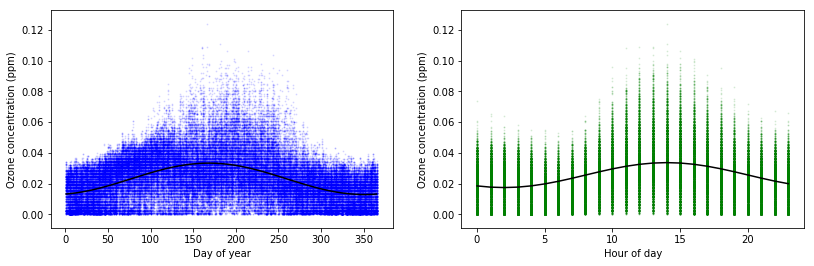

In [221]:
o3_seas_drifts = o3_complete.dropna()

o3_seas_drifts['dayofyear'] = o3_seas_drifts.index.dayofyear
o3_seas_drifts['hour'] = o3_seas_drifts.index.hour

seas_model = SeasonalModel(periods_days=[1,365]).fit(o3_seas_drifts.index.values,o3_seas_drifts['o3_ppm'])
doy_times = pd.date_range('20030101080000', periods=365, freq='D')
hod_times = pd.date_range('20030401000000', periods=24, freq='H')

fig = plt.figure(figsize=[13.5,4])
ax = fig.add_subplot(121)
ax.scatter(o3_seas_drifts['dayofyear'],o3_seas_drifts['o3_ppm'],color='blue',s=1,alpha=0.1)
ax.plot(doy_times.dayofyear,seas_model.predict(doy_times),'k-')
ax.set_xlabel('Day of year')
ax.set_ylabel('Ozone concentration (ppm)')

ax = fig.add_subplot(122)
ax.scatter(o3_seas_drifts['hour'],o3_seas_drifts['o3_ppm'],color='green',s=1,alpha=0.1)
ax.plot(hod_times.hour,seas_model.predict(hod_times),'k-')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Ozone concentration (ppm)')
plt.show()

In [86]:
conn.close()